# Preferential Sampling

We want to show that our model adjusts for preferential sampling, which leads to better estimates on a synthetic dataset.

Goals for Ellie:
- Make your own preferentially-sampled dataset (synthetic). Show your bias-adjusted method gives better estimates than just a basic GP (*completed*)
- Fit the scaling + scaling intercept coefficients
- Run gridsearch to find best scaling parameter for BCE loss in your custom_gp loss function
- Add on DeepKriging to the model

Later on goals:
- Validation -- does preferential sampling work better?
- Validation -- compare results with NOAA dataset
- Also: remove outlier at 4

In [1]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import pairwise_kernels

import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
import warnings
from itertools import product
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils


x = np.linspace(0, 10, 50)
y = np.linspace(0, 10, 50)
X, Y = np.meshgrid(x, y)

grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Define true parameters for synthetic data generation
true_scaling = 2.0  # Example true scaling parameter
true_intercept = 0.0  # Example true intercept parameter

In [2]:
# define an RBF kernel function in numpy
def RBFkernel(x1, x2, l=1.0, sigma_f=1.0, sigma_n=1e-2, noise=False):
    # compute squared distance between points in x1 and x2
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    if noise == True: # If noise=True, add noise to cov matrix by incrementing diagonal elements by (sigma_n)^2, where x1 and x2 points are identical:
        sig_tmp=sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)
        for i,x1i in enumerate(x1):
            for j,x2j in enumerate(x2):
                if np.array_equal(x1i,x2j):
                    sig_tmp[i,j]+=sigma_n**2
        return sig_tmp
    else: # if noise=False, the covariance matrix is computed directly (without noise included)
        return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [3]:
kernel = RBF(length_scale=1.0)
covariance_matrix = pairwise_kernels(grid_points, metric='rbf', gamma=1.0/(2*1.0**2))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

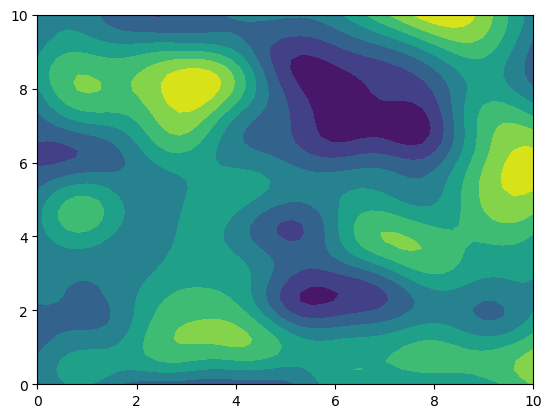

In [4]:
mean = np.zeros(grid_points.shape[0])
# Draw random samples from MVN:
np.random.seed(23)
process_values = np.random.multivariate_normal(mean, covariance_matrix)
# Create contour plot of process values

process_values_grid = process_values.reshape(X.shape)
plt.contourf(X, Y, process_values_grid)

In [5]:
def preferential_sampling(points, values, n_samples=50):
    # define the likelihood of sampling a location as a function of its value
    probabilities = softmax(true_scaling*values + true_intercept)
    # Points with higher probabilities (derived from higher values) are more likely to be sampled
    sampled_indices = np.random.choice(len(points), size=n_samples, p=probabilities, replace=False)
    return points[sampled_indices], values[sampled_indices], sampled_indices

# Sample points from the grid preferentially
sampled_points, sampled_values, sampled_indices = preferential_sampling(grid_points, process_values)

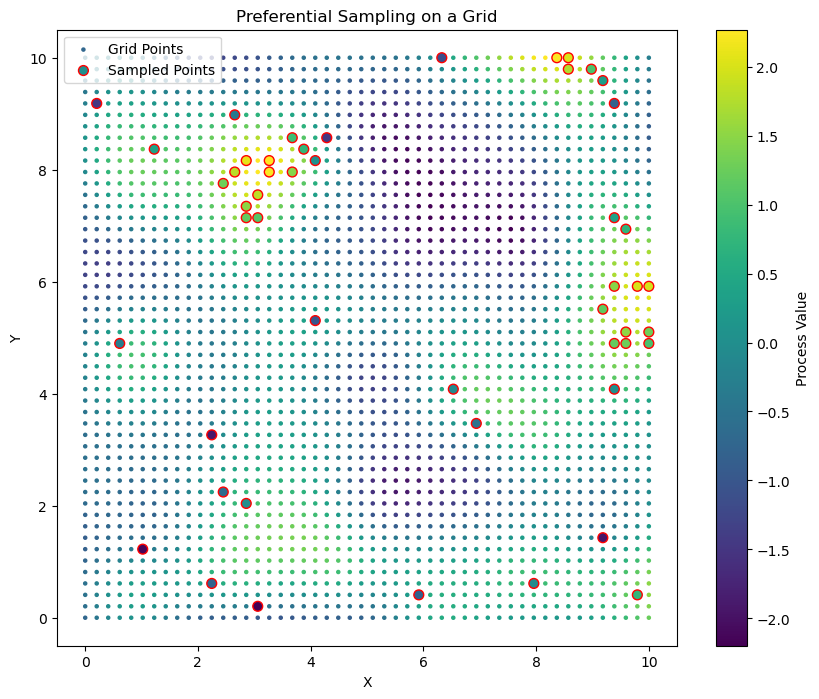

In [6]:
# Visualization with color coding based on values
plt.figure(figsize=(10, 8))
scatter = plt.scatter(grid_points[:, 0], grid_points[:, 1], c=process_values, cmap='viridis', s=5, label='Grid Points')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_values, cmap='viridis', edgecolor='red', s=50, label='Sampled Points', marker='o')
plt.colorbar(scatter, label='Process Value')
plt.title("Preferential Sampling on a Grid")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

Because we have the ground truth, we want to make sure that our method can better predict at the unsampled locations (i.e., the MSE is lower on the held-out data).

In [7]:
# Split data into training and testing:
n_samples = 50
all_indices = np.arange(len(grid_points))
unsampled_indices = np.setdiff1d(all_indices, sampled_indices) # finds set difference

# Training data (preferentially sampled)
X_train = sampled_points
y_train = sampled_values
# Testing data (unsampled)
X_test = grid_points[unsampled_indices]
y_test = process_values[unsampled_indices]

In [8]:
# Fit and predict with basic GP (no preferential sampling adjustment)

from sklearn.gaussian_process import GaussianProcessRegressor
# Initialize and fit the basic GP model
basic_gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
basic_gp.fit(X_train, y_train)
y_pred_basic, y_std_basic = basic_gp.predict(X_test, return_std=True)

In [9]:
def custom_gp_predict(X_train, y_train, X_test, K, iters=1000, lr=1., scaling=1.0, scaling_intercept=0.0):

    observed = np.arange(X_train.shape[0])
    M = np.zeros(X_train.shape[0] + X_test.shape[0])
    M[observed] = 1
    M = torch.tensor(M, dtype=torch.float32)

    z_inferred = torch.zeros(X_train.shape[0] + X_test.shape[0], requires_grad=True)

    # trainable parameters for the observation link to z
    scaling = torch.tensor(scaling, requires_grad=False, dtype=torch.float32)
    intercept = torch.tensor(scaling_intercept, requires_grad=False, dtype=torch.float32)

    optimizer = optim.Adam([z_inferred, scaling, intercept], lr=lr)
    observation_matching = nn.MSELoss()

    # Create tensors for the observed points and values
    X_train_pt = torch.tensor(X_train, dtype=torch.float32)
    y_train_pt = torch.tensor(y_train, dtype=torch.float32)
    X_combined = np.vstack((X_train, X_test))
    K_combined = RBFkernel(X_combined, X_combined, l=1., sigma_f=1., noise=True, sigma_n=0.01)
    K_inv_pt = torch.inverse(torch.tensor(K_combined, dtype=torch.float32))

    # Training loop
    for iter in range(iters):
        optimizer.zero_grad()

        loss_1 = 0.5 * torch.matmul(torch.matmul(z_inferred, K_inv_pt), z_inferred) / z_inferred.shape[0]
        loss_2 = observation_matching(y_train_pt, z_inferred[observed])
        loss_3 = -torch.mean(M * torch.log(torch.sigmoid(intercept + scaling * z_inferred)) + (1 - M) * torch.log(1 - torch.sigmoid(intercept + scaling * z_inferred)))
        loss = loss_1 + loss_2 + loss_3

        # Calculate the gradient
        loss.backward()
        optimizer.step()
        if iter % 100 == 0:
            print(f'Iteration {iter}, Loss: {loss.item()}')

    # Extract inferred values for test data
    z_inferred_values = z_inferred.detach().numpy()
    y_pred_custom = z_inferred_values[len(X_train):]

    return y_pred_custom, scaling.item(), intercept.item()

In [10]:
# Use the true parameters to predict and calculate MSE
from sklearn.metrics import mean_squared_error
myK = RBFkernel(X_train, X_train, l=1.0, sigma_f=1.0, noise=True, sigma_n=0.01)
y_pred_custom, learned_scaling, learned_intercept = custom_gp_predict(X_train, y_train, X_test, myK, iters=1000, lr=0.01, scaling=true_scaling, scaling_intercept=true_intercept)

# Calculate MSE using true parameters
mse_true_params = mean_squared_error(y_test, y_pred_custom)

print(f'MSE with True Parameters: {mse_true_params}')
print(f'Learned Scaling: {learned_scaling}')
print(f'Learned Intercept: {learned_intercept}')

Iteration 0, Loss: 2.650674819946289
Iteration 100, Loss: 1.061139702796936
Iteration 200, Loss: 0.4188176393508911
Iteration 300, Loss: 0.21858887374401093
Iteration 400, Loss: 0.15819130837917328
Iteration 500, Loss: 0.13291968405246735
Iteration 600, Loss: 0.11854607611894608
Iteration 700, Loss: 0.1092778891324997
Iteration 800, Loss: 0.10299397259950638
Iteration 900, Loss: 0.0985141471028328
MSE with True Parameters: 0.42099721176448707
Learned Scaling: 1.2123034000396729
Learned Intercept: -3.680342674255371


### Grid Search
To find best values for ```scaling```, ```scaling_intercept``` parameters

In [11]:
from sklearn.metrics import mean_squared_error
# Define ranges for grid search
scaling_range = np.linspace(1.0, 3.0, 3) 
scaling_intercept_range = np.linspace(-1.0, 1.0, 3)

# Perform grid search
best_mse = float('inf')
best_scaling = None
best_intercept = None

for scaling, intercept in product(scaling_range, scaling_intercept_range):
    myK = RBFkernel(X_train, X_train, l=1.0, sigma_f=1.0, noise=True, sigma_n=0.01)
    y_pred_custom, learned_scaling, learned_intercept = custom_gp_predict(X_train, y_train, X_test, myK, iters=1000, lr=0.01, scaling=scaling, scaling_intercept=intercept)
    mse_custom = mean_squared_error(y_test, y_pred_custom)
    
    if mse_custom < best_mse:
        best_mse = mse_custom
        best_scaling = scaling
        best_intercept = intercept

print(f'Best MSE: {best_mse}')
print(f'Best Scaling: {best_scaling}')
print(f'Best Intercept: {best_intercept}')

Iteration 0, Loss: 2.2907891273498535
Iteration 100, Loss: 0.8701893091201782
Iteration 200, Loss: 0.31796005368232727
Iteration 300, Loss: 0.16213810443878174
Iteration 400, Loss: 0.12152926623821259
Iteration 500, Loss: 0.10740923136472702
Iteration 600, Loss: 0.10003338754177094
Iteration 700, Loss: 0.09543536603450775
Iteration 800, Loss: 0.09235384315252304
Iteration 900, Loss: 0.09026221185922623
Iteration 0, Loss: 2.650674819946289
Iteration 100, Loss: 1.0560595989227295
Iteration 200, Loss: 0.4141509532928467
Iteration 300, Loss: 0.21930192410945892
Iteration 400, Loss: 0.15927422046661377
Iteration 500, Loss: 0.13390980660915375
Iteration 600, Loss: 0.11943075060844421
Iteration 700, Loss: 0.11003036051988602
Iteration 800, Loss: 0.10360044240951538
Iteration 900, Loss: 0.09905493259429932
Iteration 0, Loss: 3.2507894039154053
Iteration 100, Loss: 1.421649694442749
Iteration 200, Loss: 0.624554455280304
Iteration 300, Loss: 0.3379637598991394
Iteration 400, Loss: 0.23280662298

In [12]:
# Compare the recovered parameters with the true parameters
print(f'Recovered Scaling: {best_scaling}, True Scaling: {true_scaling}')
print(f'Recovered Intercept: {best_intercept}, True Intercept: {true_intercept}')

Recovered Scaling: 3.0, True Scaling: 2.0
Recovered Intercept: 1.0, True Intercept: 0.0


### Compare prediction methods (Basic GP vs Custom GP)

In [13]:
s = 1.0
n = 0.01
myK = RBFkernel(X_train, X_train, l=1., sigma_f=s, noise=True, sigma_n=n)
y_pred_custom, learned_scaling, learned_intercept = custom_gp_predict(X_train, y_train, X_test, myK, iters=1000, lr=0.01, scaling=true_scaling, scaling_intercept=true_intercept)

# Calculate MSE for both methods
basic_gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
basic_gp.fit(X_train, y_train)
y_pred_basic, y_std_basic = basic_gp.predict(X_test, return_std=True)
mse_basic = mean_squared_error(y_test, y_pred_basic)
mse_custom = mean_squared_error(y_test, y_pred_custom)

# Print the MSE results
print(f'MSE (Basic GP): {mse_basic}')
print(f'MSE (Custom GP): {mse_custom}')
print(f'Learned Scaling: {learned_scaling}')
print(f'Learned Intercept: {learned_intercept}')

Iteration 0, Loss: 2.650674819946289
Iteration 100, Loss: 1.061139702796936
Iteration 200, Loss: 0.4188176393508911
Iteration 300, Loss: 0.21858887374401093
Iteration 400, Loss: 0.15819130837917328
Iteration 500, Loss: 0.13291968405246735
Iteration 600, Loss: 0.11854607611894608
Iteration 700, Loss: 0.1092778891324997
Iteration 800, Loss: 0.10299397259950638
Iteration 900, Loss: 0.0985141471028328
MSE (Basic GP): 0.681191211327091
MSE (Custom GP): 0.42099721176448707
Learned Scaling: 1.2123034000396729
Learned Intercept: -3.680342674255371


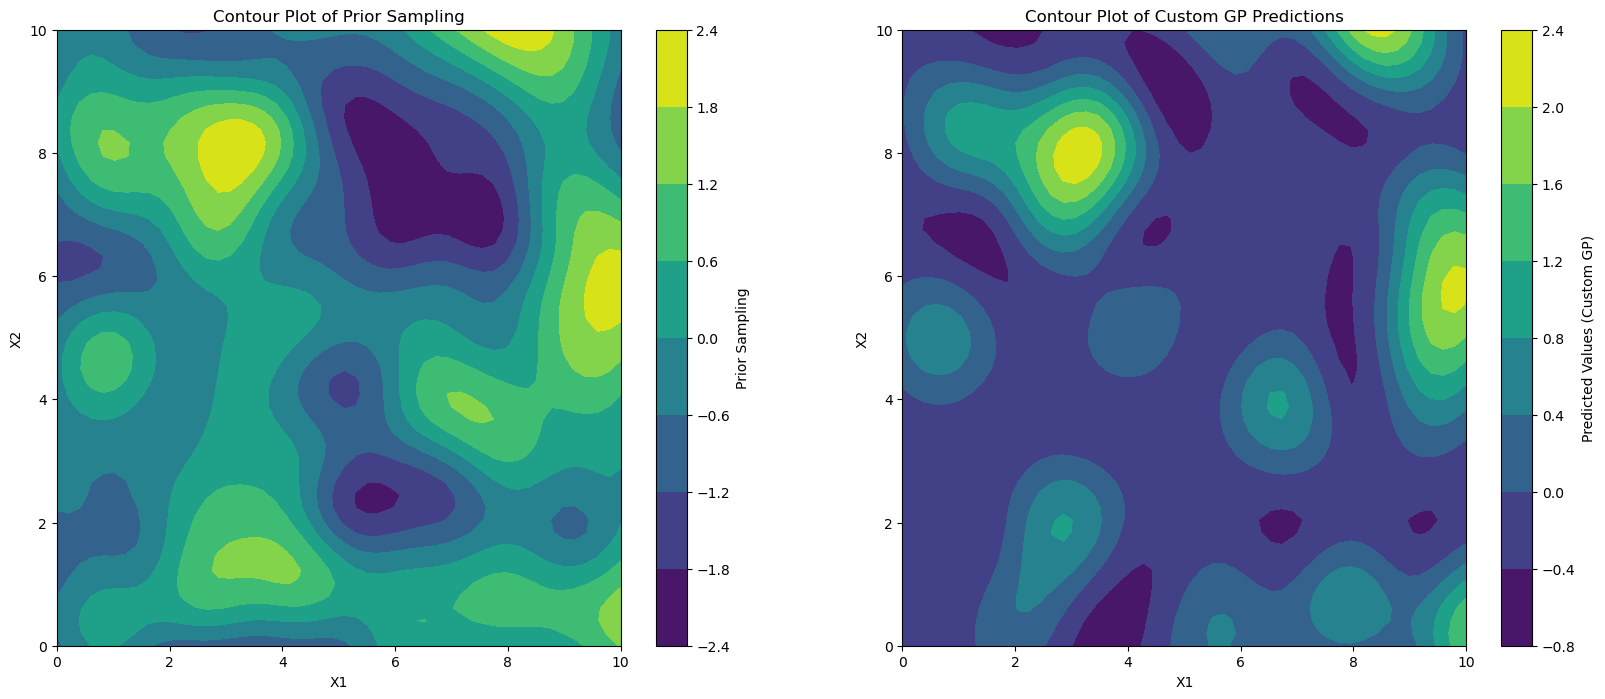

In [14]:
# Assuming X_test is 2D with shape (n_samples, 2)
x1 = X_test[:, 0]
x2 = X_test[:, 1]
x1_grid, x2_grid = np.meshgrid(np.linspace(x1.min(), x1.max(), 50), np.linspace(x2.min(), x2.max(), 50))

# Interpolate y_pred_custom to match the grid shape
from scipy.interpolate import griddata
y_pred_custom_grid = griddata(X_test, y_pred_custom, (x1_grid, x2_grid), method='cubic')
process_values_grid = process_values.reshape(x1_grid.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

contour1 = ax[0].contourf(x1_grid, x2_grid, process_values_grid, cmap='viridis')
fig.colorbar(contour1, ax=ax[0], label='Prior Sampling')
ax[0].set_title("Contour Plot of Prior Sampling")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

contour2 = ax[1].contourf(x1_grid, x2_grid, y_pred_custom_grid, cmap='viridis')
fig.colorbar(contour2, ax=ax[1], label='Predicted Values (Custom GP)')
ax[1].set_title("Contour Plot of Custom GP Predictions")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.show()


/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_10054/2920487378.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 3 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, label='Process Value')


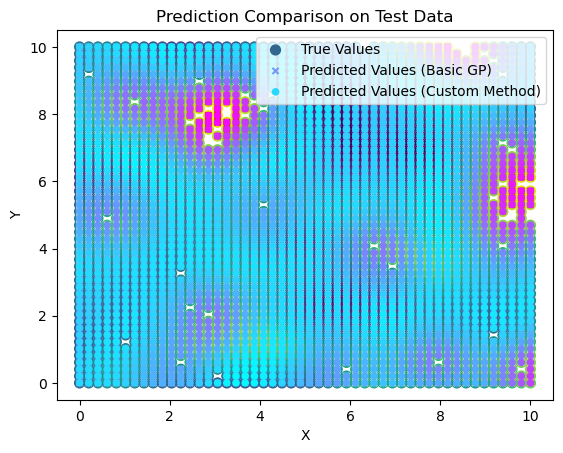

In [15]:
# Visualize the difference in results
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', s=50, label='True Values')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_basic, cmap='coolwarm', s=20, marker='x', label='Predicted Values (Basic GP)')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_custom, cmap='cool', s=20, marker='o', label='Predicted Values (Custom Method)')
plt.colorbar(scatter, label='Process Value')
plt.title("Prediction Comparison on Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()